<a href="https://colab.research.google.com/github/Sahil-18/Memes_Vs_Notes/blob/master/CNN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import scipy
from scipy import ndimage
%matplotlib inline

In [2]:
from torch.autograd import variable
from torch.nn import Linear,ReLU,CrossEntropyLoss,Conv2d,MaxPool2d,Softmax, BatchNorm2d,Sequential,Module
from torch.optim import Adam

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
# Loading Dataset
import os
from IPython.display import clear_output
from matplotlib.pyplot import imshow

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
memes_0 = os.listdir("/content/gdrive/My Drive/Stage 3/meme")         # Data link of memes stored at drive
memes_total = len(memes_0)
notes_0 = os.listdir("/content/gdrive/My Drive/Stage 3/note")         # Data link of notes stored at drive
notes_total = len(notes_0)

In [16]:
X_meme=[]
Y_meme=[]
i=0
for meme in memes_0:
  clear_output(wait=True)
  r_path=f'/content/gdrive/My Drive/Stage 3/meme/{meme}'      # Data link of memes stored at drive
  image=np.array(Image.open(r_path))
  X_meme.append(image)
  Y_meme.append(1)
  i += 1
  print(f"Progress: {i}/{memes_total}", flush=True)

Progress: 800/800


In [17]:
X_note=[]
Y_note=[]
i=0
for note in notes_0:
  clear_output(wait=True)
  w_path=f'/content/gdrive/My Drive/Stage 3/note/{note}'    # Data link of notes stored at drive
  image=np.array(Image.open(w_path))
  X_note.append(image)
  Y_note.append(0)
  i += 1
  print(f"Progress: {i}/{notes_total}", flush=True)

Progress: 800/800


In [8]:
X_meme=np.array(X_meme)
Y_meme=np.array(Y_meme)

X_note=np.array(X_note)
Y_note=np.array(Y_note)

In [9]:
def Input_parameters(X_meme,X_note,Y_meme,Y_note):
  from sklearn .model_selection import train_test_split
  x_meme_train, x_meme_test, y_meme_train, y_meme_test = train_test_split(X_meme,Y_meme,test_size =0.25,random_state = 50)
  x_meme_dev, x_meme_test, y_meme_dev, y_meme_test = train_test_split(x_meme_test,y_meme_test,test_size =0.5,random_state = 50)
  x_note_train, x_note_test, y_note_train, y_note_test = train_test_split(X_note,Y_note,test_size =0.25,random_state = 50)
  x_note_dev, x_note_test, y_note_dev, y_note_test = train_test_split(x_note_test,y_note_test,test_size =0.5,random_state = 50)

  x_test=x_meme_test+x_note_test
  x_train=x_meme_train+x_note_train
  x_dev=x_meme_dev+x_note_dev
  y_test=y_meme_test+y_note_test
  y_train=y_meme_train+y_note_train
  y_dev=y_meme_dev+y_note_dev

  np.random.seed(3)
  np.random.shuffle(x_train)
  np.random.seed(3)
  np.random.shuffle(y_train)
  np.random.seed(3)
  np.random.shuffle(x_dev)
  np.random.seed(3)
  np.random.shuffle(y_dev)
  np.random.seed(3)
  np.random.shuffle(x_test)
  np.random.seed(3)
  np.random.shuffle(y_test)

  return x_train,x_dev,x_test,y_train,y_dev,y_test

In [10]:
x_train,x_dev,x_test,y_train,y_dev,y_test=Input_parameters(X_meme,X_note,Y_meme,Y_note)
x_train=torch.from_numpy(x_train)
x_dev=torch.from_numpy(x_dev)
x_test=torch.from_numpy(x_test)
x_train=x_train.permute(0,3,1,2)
x_dev=x_dev.permute(0,3,1,2)
x_test=x_test.permute(0,3,1,2)

y_train=torch.from_numpy(y_train)
y_dev=torch.from_numpy(y_dev)
y_test=torch.from_numpy(y_test)

print(y_train.shape)
print(x_train.shape)

torch.Size([600])
torch.Size([600, 3, 64, 64])


Forming CNN architecture using 3 Convolutional layers to extract features from image

Then using one fully connected dense layer to classify those features

In [11]:
class Net(Module):
  def __init__(self):
    super(Net, self).__init__()
    self.cnn_layers = Sequential(
        # Defining 2D convolution layer
        Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        BatchNorm2d(16),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2,stride=2),

        # Defining another 2D convolution layer
        Conv2d(16,32,kernel_size=3,stride=1,padding=1),
        BatchNorm2d(32),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2,stride=2),

        # Defining another 2D convolution layer
        Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        BatchNorm2d(64),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2,stride=2),
        
        )
    
    self.linear_layers=Sequential(
        Linear(8*64*8,256),
        ReLU(),
        Linear(256,64),
        ReLU(),
        Linear(64,2),
    )
  # Defining forward pass

  def forward(self,x):
    x=self.cnn_layers(x)
    x=x.view(x.shape[0],-1)
    x=self.linear_layers(x)
    return x


In [12]:
# Calling this model and defining optimization and loss of the model
model = Net()
# defining optimization
optimizer=Adam(model.parameters(), lr=0.05)
# defining loss of the model
criterion= CrossEntropyLoss()

In [13]:

# Defining a function to train the model

def train(epoch,x_train,y_train,x_dev,y_dev):
  model.train()
  tr_loss=0
  # training set gaining
  train_x,train_y= x_train,y_train
  # dev set gaining
  dev_x,dev_=x_dev, y_dev

  # clearing gradients of model parameters
  optimizer.zero_grad()

  # prediction of output for trainig and dev set
  output_train=model(train_x.float())
  output_dev=model(dev_x.float())
   
  # calculating loss over training and dev set
  loss_train=criterion(output_train,y_train)
  loss_dev=criterion(output_dev,y_dev)
  train_losses.append(loss_train)
  dev_losses.append(loss_dev)

  # computing updated wieghts of all model parameters
  loss_train.backward()   # gradient calculation of parameters
  optimizer.step()  # update parameter based on current grads
  tr_loss = loss_train.item()
  print('Epoch : ',epoch+1, '\t', 'loss :', tr_loss)

Epoch :  1 	 loss : 0.6496109366416931
Epoch :  2 	 loss : 0.0
Epoch :  3 	 loss : 0.0
Epoch :  4 	 loss : 0.0
Epoch :  5 	 loss : 0.0
Epoch :  6 	 loss : 0.0
Epoch :  7 	 loss : 0.0
Epoch :  8 	 loss : 0.0
Epoch :  9 	 loss : 0.0
Epoch :  10 	 loss : 0.0


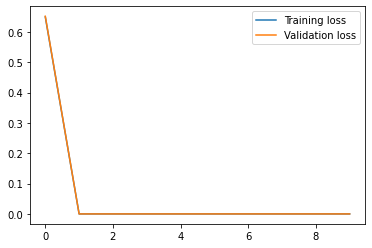

In [14]:
# training the model over 10 epoch

n_epoch=10
train_losses=[]
dev_losses=[]

for epoch in range(n_epoch):
  train(epoch,x_train,y_train,x_dev,y_dev)

# Plotting the training and dev loss
plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Validation loss')
plt.legend()
plt.show()

In [125]:
# prediction for training set
import math
with torch.no_grad():
    output = model(x_train.float())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
print(accuracy_score(y_train, predictions))

1.0


In [122]:
with torch.no_grad():
    output = model(x_dev.float())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
print(accuracy_score(y_dev, predictions))

1.0


In [123]:
with torch.no_grad():
    output = model(x_test.float())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
print(accuracy_score(y_test, predictions))

1.0
